# Fetching the Data

In [30]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
# Fetching the data

import os
import tarfile
from six.moves import urllib


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
import pandas as pd

# Writing function to load the housing data file
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Naming the datafile
house = load_housing_data()

# Data Profiling

In [6]:
house.head() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# Getting info about dataset - total rows, var types, non-null values
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# View categories of ocean proximity field
house["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# Summary of all numerical attributes
house.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


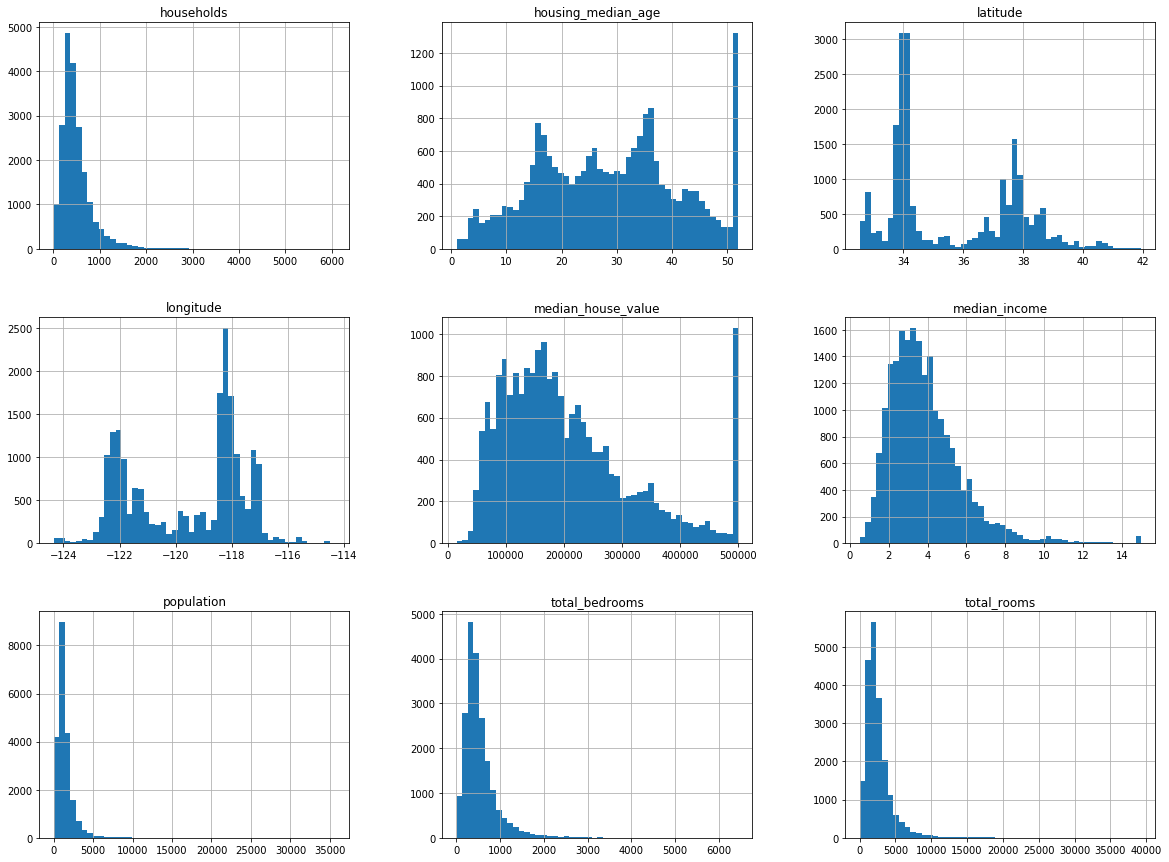

In [10]:
# Plot a histogram for each numerical attribute
%matplotlib inline 
import matplotlib.pyplot as plt
house.hist(bins=50, figsize=(20,15))
plt.show()

#### Some observations: 
1- Median income is not in USD - data is scaled and capped at 15
2- Housing median age and median house value were also capped. Median house values is an issue because that is going to be the target attribute. Therefore, ML algorithms may learn that prices never go beyond that limit.

If more precise predictions are needed beyond $500k, will need to either collect proper labels for districts whose labels are capped, remove those districts from the training and test set

3- These attributes have very different scales
4- Tail-heavy attributes may make it harder for some ML algorithms to detect patterns. May have to transform these attributes to have more bell-shaped distributions.

# Creating a test set

In [11]:
# Will take a stratified sample based on income
import numpy as np

# First generating an income category attribute 
# limiting the number of groups and putting all those over 5 in a separate group
house["income_cat"] = np.ceil(house["median_income"]/1.5)
house["income_cat"].where(house["income_cat"] < 5, 5.0, inplace=True)

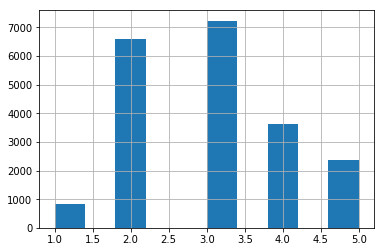

In [12]:
house["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_index, test_index in split.split(house, house["income_cat"]):
    strat_train_set = house.loc[train_index]
    strat_test_set = house.loc[test_index]

In [14]:
# Checking to see how it worked
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [15]:
# Creating a copy so I can play with the data without harming the training set
house = strat_train_set.copy()

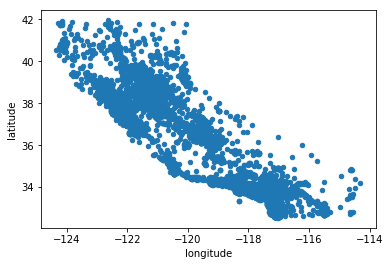

In [16]:
# Creating a scatterplot of all districts to visualize the data 
house.plot(kind="scatter", x="longitude",y="latitude")

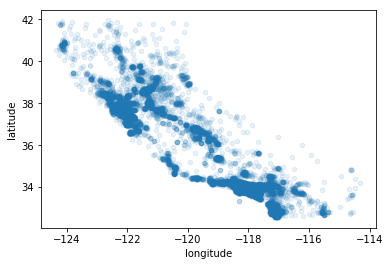

In [17]:
# Looks like California. Setting alpha option to 0.1 to more easily visualize the high-density areas
house.plot(kind="scatter", x="longitude",y="latitude",alpha=0.1)

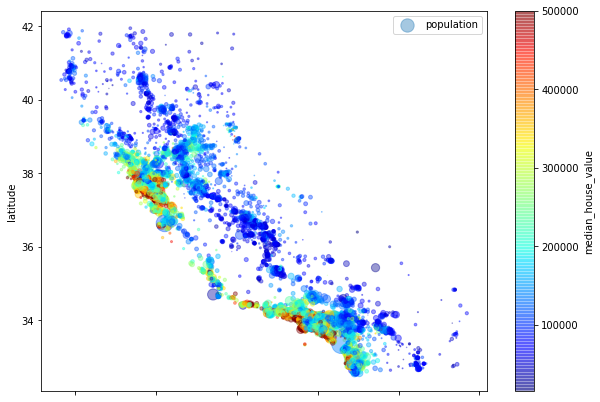

In [18]:
# Can see clustering around bay area, LA, San Diego, Sacramento...
# Now will look at housing prices
house.plot(kind="scatter", x="longitude",y="latitude",alpha=0.4,
           s=house["population"]/100, label="population", figsize=(10,7), 
           c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [19]:
# The above plot tells us housing prices are very correlated to proximity to urban areas and the ocean
# May want to use a clustering algorithm to detect the main clusters
# and add new features that measure the proximity to the cluster centers



In [24]:
# Computing the correlation coefficient between every pair of attributes
corr_matrix = house.corr()

# Now look at how much each attribute correlates with the median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688853
income_cat            0.644701
total_rooms           0.135447
housing_median_age    0.110739
households            0.067613
total_bedrooms        0.050304
population           -0.022356
longitude            -0.046048
latitude             -0.144789
Name: median_house_value, dtype: float64

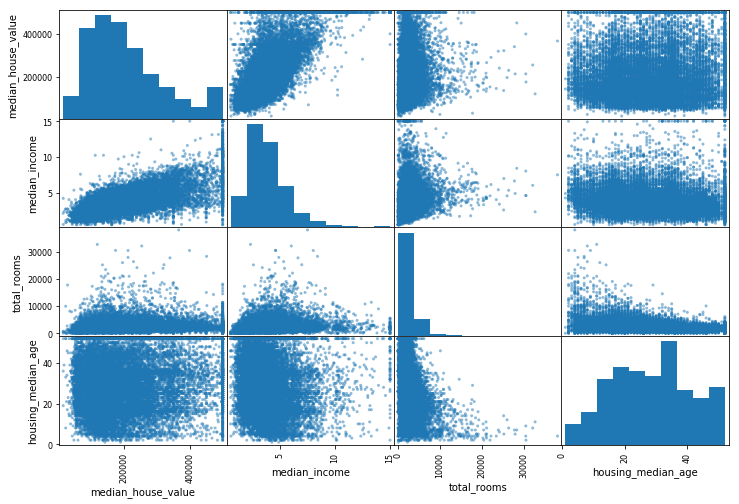

In [27]:
# Use the scatter_matrix function to check for correlations
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] 
scatter_matrix(house[attributes], figsize=(12,8))
plt.show()
# Notice rather than displaying straight lines for variable against itself, pandas plots a histogram of values
# Other options are available


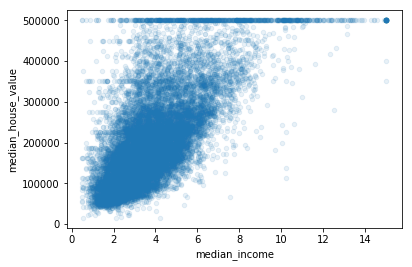

In [29]:
# Median income looks the most promising to predict the median house value
house.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)
plt.show()

In [42]:
# Note: horizontal lines appear around 500K, 450K, 350K, 280K, and a few values of median_house_value
# May want to remove the corresponding districts to prevent algorithm from learning to reproduce data quirks

# Checking out the top median_house_value values by number of occurrences
house.groupby("median_house_value").count().sort_values(by="median_income",ascending=False).nlargest(20,"median_income")["median_income"]


median_house_value
500001.0    787
137500.0     92
162500.0     91
112500.0     79
187500.0     74
225000.0     69
350000.0     66
87500.0      66
275000.0     53
150000.0     52
175000.0     52
100000.0     48
67500.0      48
125000.0     44
250000.0     38
200000.0     37
156300.0     31
450000.0     31
118800.0     28
193800.0     28
Name: median_income, dtype: int64